# Hedging

Some of the volatility in the returns of an asset is due to the effects of a separate, measurable economic factor, such as fluctuations in the market at large. We can protect against such risk by shorting an index which measures the market, like the S&P 500. That way, when our returns fall due to the market falling, our loss from our investment in the asset and our gain from being short in the market index will cancel out. Similarly, increasing asset returns due to the rising market will also be counterbalanced, so that the value of our holding reflects the performance of the asset relative to overall market conditions.

# Computing beta

In order to determine how much to short our benchmark, we need to know how correlated it is with our asset. The more correlated they are, the more we need to hedge in order to cancel out the effects of market movement on the returns. This correlation coefficient is $\beta$, which is defined to satisfy
$$r_a \approx \alpha + \beta r_b$$
where $r_a$ are the returns of our asset and $r_b$ are the returns of the benchmark. That is, it is the slope of the best-fit line to the points $(r_a(t), r_b(t))$.  We want to find $\beta$ that minimizes the sum of the squares of the errors, $\sum_t (r_a - \alpha - \beta r_b)^2$, but in practice we can just use Python's `statsmodels` library.

Note that $\beta$ represents the correlation of the asset and the benchmark; while $\alpha$ represents how much the asset's returns are shifted up from the benchmark returns, that is, the returns that are independent of the market! So, in beta-hedging, we will build a portfolio that has the same $\alpha$ but with $\beta \approx 0$ by subtracting off $\beta r_b$.

In [15]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

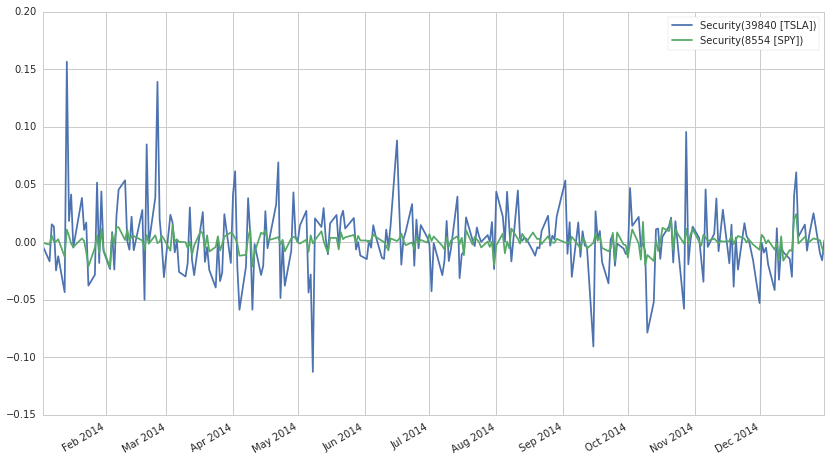

In [16]:
# Get data for the specified period and stocks
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.legend();

Now we can perform the regression to find $\alpha$ and $\beta$:

In [18]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 0.00108062811902
beta: 1.92705010047


If we plot the line $\alpha + \beta r_a$, we can see that it does indeed look like the line of best fit:

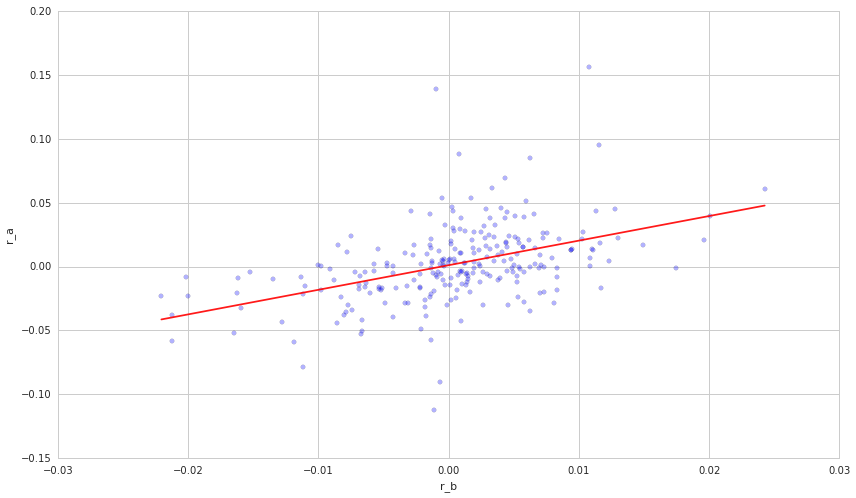

In [19]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("r_b")
plt.ylabel("r_a")

plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red

# Implementing hedging

Now that we know how much to hedge, let's see how it affects our returns. We will build our portfolio using the asset and the benchmark, weighing the benchmark by $-\beta$ (negative since we are short in it).

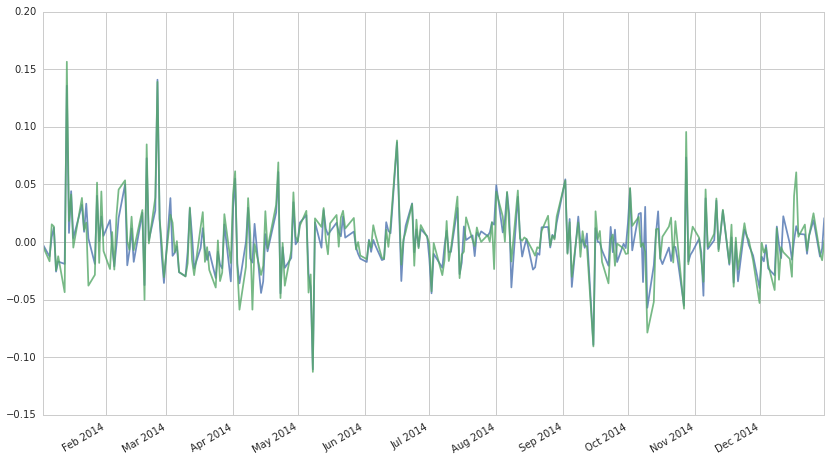

In [12]:
# Construct a portfolio with beta hedging
portfolio = r_b.map(lambda x: -1*beta*x) + r_a

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.8)
r_a.plot(alpha=0.8);

It looks like the portfolio return follows the asset alone fairly closely, but without the large spikes. We can quantify the difference in their performances by computing the mean returns and the volatilities (standard deviations of returns) for both:

In [13]:
print "means: ", portfolio.mean(), r_a.mean()
print "volatilities: ", portfolio.std(), r_a.std()

means:  0.00108062811902 0.00202262496904
volatilities:  0.0272298767724 0.0304875405804


We've decreased volatility at the expense of some returns. Let's check that the alpha is the same as before, while the beta has been eliminated:

In [20]:
P = portfolio.values
alpha, beta = linreg(X,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 0.00108062811902
beta: 3.85108611667e-16


Note that we developed our hedging strategy using historical data. We can check that it is still valid out of sample by checking the alpha and beta values of the asset and the hedged portfolio in a different time frame:

In [25]:
# Get data for a different time frame:
start = '2015-01-01'
end = '2015-06-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# Repeat the process from before to compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print 'Asset:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

# Create hedged portfolio and compute alpha and beta
portfolio = r_b.map(lambda x: -1*beta*x) + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print 'Portfolio:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

Asset:
alpha: 0.00114816439781
beta: 1.04339843544
Portfolio:
alpha: 0.00114816439781
beta: 1.0126448291e-15


The beta of the portfolio is negligible, while the alpha is the same as of the stock. This is exactly what we wanted!

# Other types of hedging

Although we will not execute them here, there are strategies for hedging that may be better suited for other investment approaches. One is pairs trading, in which a second asset is used in place of the benchmark here. This would allow you, for instance, to cancel out the volatility in an industry by being long in the stock of one company and short in the stock of another company in the same industry. Another is long/short equity, in which you buy long equities whose value you expect to increase while selling short those whose value you expect to decrease. This way, if the stock price shifts in the opposite direction from what you expected due to the movement of the market as a whole, you are not penalized. This works well when trading a large variety of assets, so that they represent the movement of the market well.